In [1]:
import pandas as pd
import numpy as np

In [2]:
# 读取数据
df = pd.read_csv("METABRIC_RNA_Mutation.csv", low_memory=False)

# 分离三部分
clinical_cols = df.columns[:31]  # 0-30
gene_cols = df.columns[31:520]   # 31-519 (489 genes)
mutation_cols = df.columns[520:] # 520-692 (173 columns)

# 筛选tumor_size非空样本
df_clean = df[df["tumor_size"].notnull()].copy()
print(f"原始样本量: {len(df)}, 有效样本量: {len(df_clean)}, 缺失率: {(1-len(df_clean)/len(df)):.2%}")

原始样本量: 1904, 有效样本量: 1884, 缺失率: 1.05%


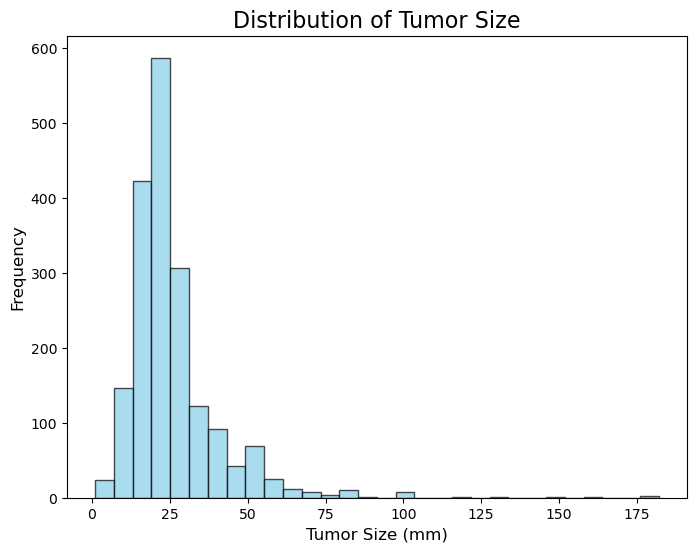

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_clean["tumor_size"], bins=30, edgecolor='black', color='skyblue', alpha=0.7)
ax.set_title('Distribution of Tumor Size', fontsize=16)
ax.set_xlabel('Tumor Size (mm)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [4]:
y = np.log(df_clean["tumor_size"] + 1)  # 因变量转换，加1是为了防止原始数据中有0，因为log(0)未定义

In [5]:
import seaborn as sns
from scipy.stats import boxcox, probplot, shapiro, skew, kurtosis

if (df_clean["tumor_size"] <= 0).any():
    print("警告：数据中存在小于等于0的值，无法直接进行Box-Cox变换。")
    print("将使用一个极小的正数（如1e-6）替换0值，或使用log1p变换。")
    data_for_boxcox = df_clean["tumor_size"] + 1e-6
else:
    data_for_boxcox = df_clean["tumor_size"]

# boxcox 函数会返回两个值：转换后的数组和最佳的 lambda 值
y_boxcox, lambda_value = boxcox(data_for_boxcox)

print(f"Box-Cox 变换找到的最佳 lambda (λ) 值为: {lambda_value:.4f}")

Box-Cox 变换找到的最佳 lambda (λ) 值为: 0.1995


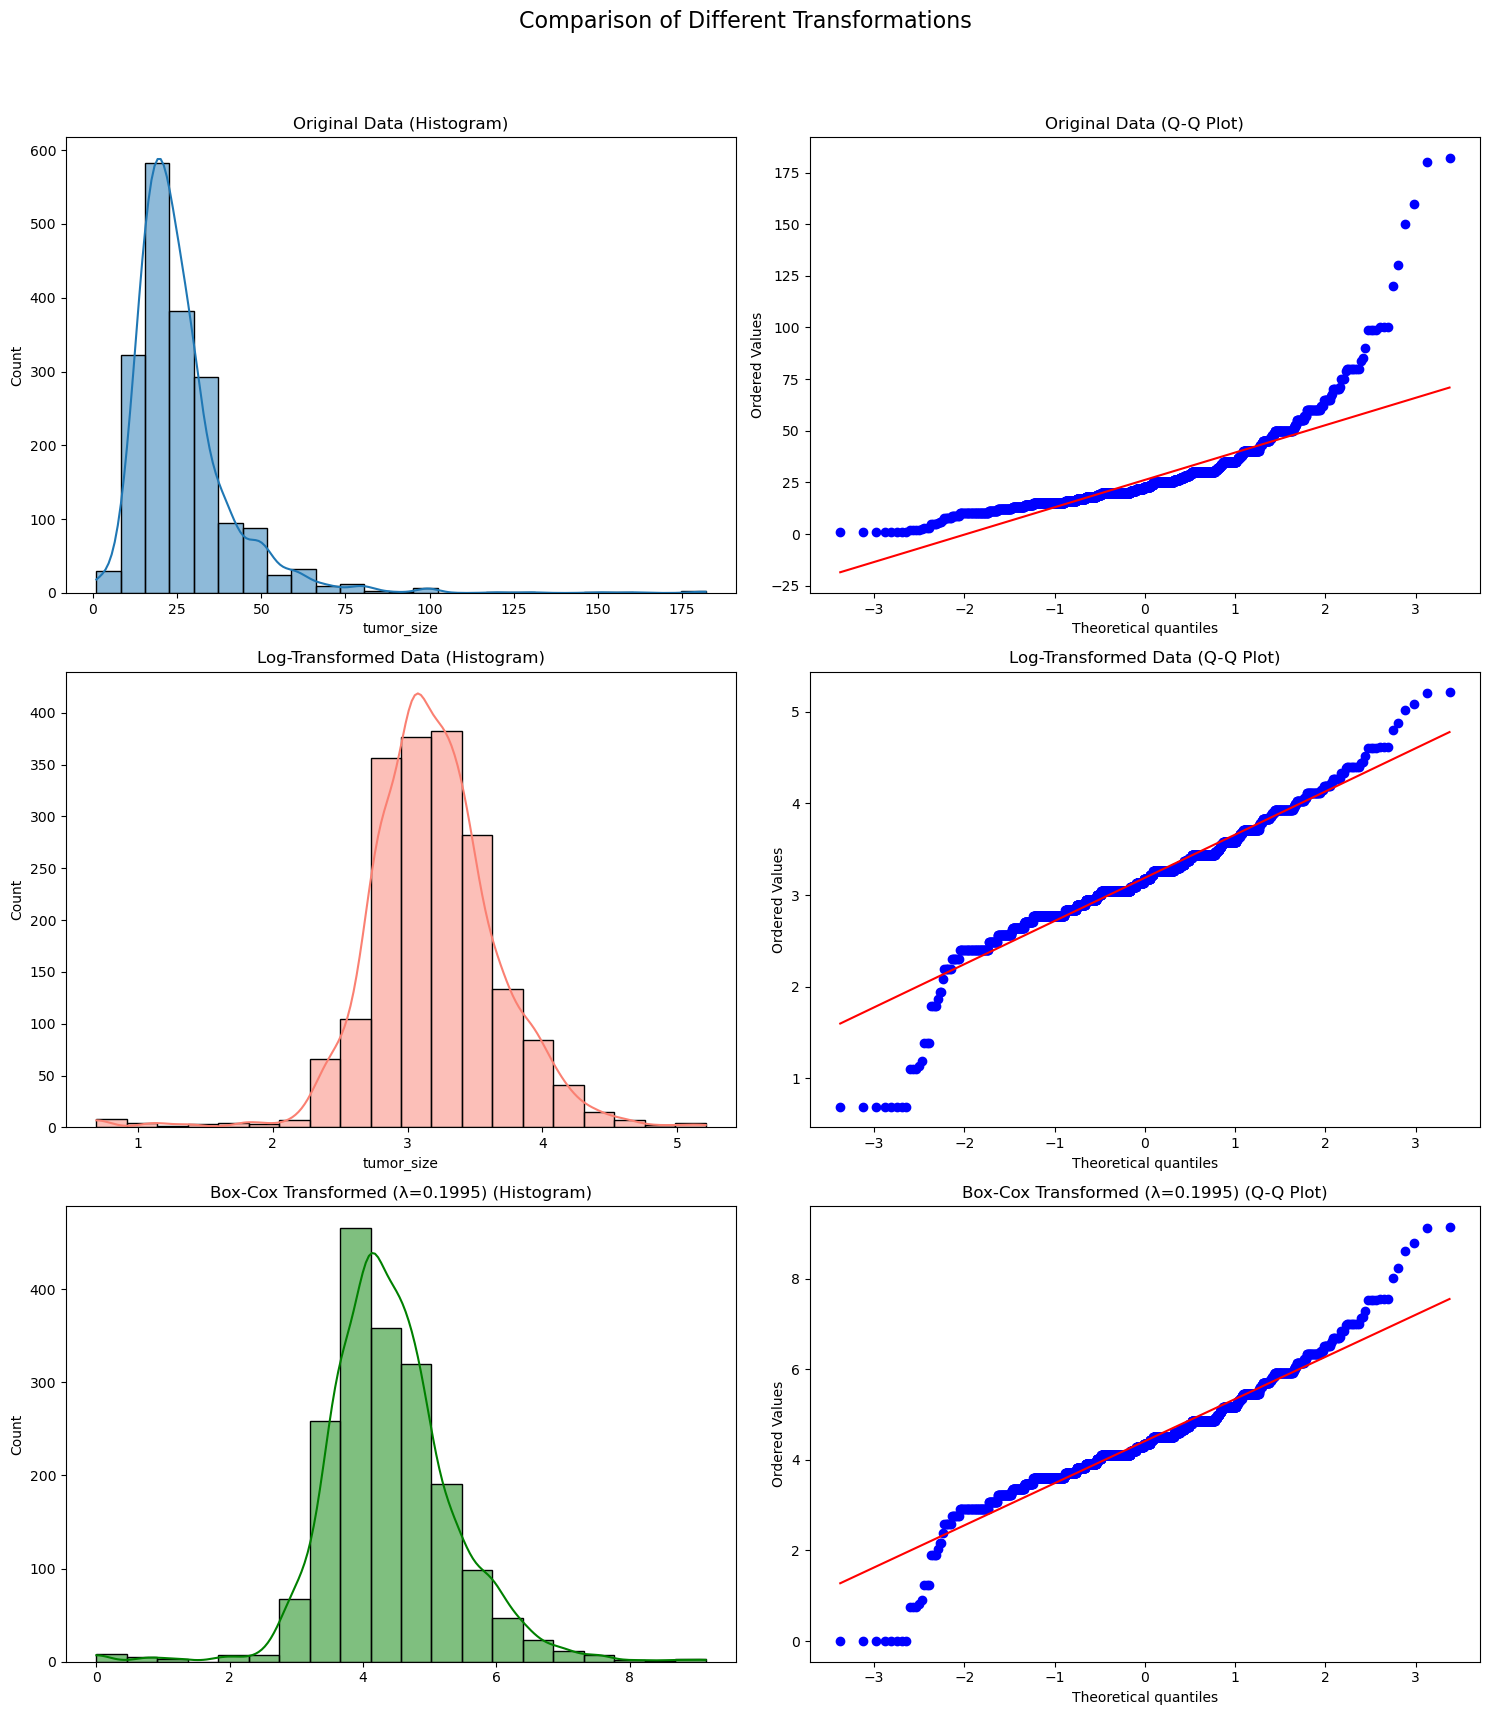

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Comparison of Different Transformations', fontsize=16)

# --- 原始数据 ---
sns.histplot(df_clean["tumor_size"], kde=True, ax=axes[0, 0], bins=25)
axes[0, 0].set_title('Original Data (Histogram)')
probplot(df_clean["tumor_size"], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Original Data (Q-Q Plot)')

# --- 对数变换 ---
y_log = np.log(df_clean["tumor_size"] + 1)
sns.histplot(y_log, kde=True, ax=axes[1, 0], color='salmon', bins=20)
axes[1, 0].set_title('Log-Transformed Data (Histogram)')
probplot(y_log, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Log-Transformed Data (Q-Q Plot)')

# --- Box-Cox 变换 ---
sns.histplot(y_boxcox, kde=True, ax=axes[2, 0], color='green', bins=20)
axes[2, 0].set_title(f'Box-Cox Transformed (λ={lambda_value:.4f}) (Histogram)')
probplot(y_boxcox, dist="norm", plot=axes[2, 1])
axes[2, 1].set_title(f'Box-Cox Transformed (λ={lambda_value:.4f}) (Q-Q Plot)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [7]:
data_list = {
    "Original Data": df_clean["tumor_size"],
    "Log-Transformed": y_log,
    f"Box-Cox (λ={lambda_value:.4f})": y_boxcox
}

for name, data in data_list.items():
    s = skew(data)
    k = kurtosis(data)
    print(f"{name}:")
    print(f"  偏度: {s:.4f}, 峰度: {k:.4f}")

Original Data:
  偏度: 3.2725, 峰度: 20.8578
Log-Transformed:
  偏度: -0.3978, 峰度: 3.9978
Box-Cox (λ=0.1995):
  偏度: 0.1272, 峰度: 3.4074


In [8]:
# 临床变量处理
X_clinical = df_clean[[
    "age_at_diagnosis",
    "neoplasm_histologic_grade",
    "pam50_+_claudin-low_subtype",
    "er_status",
    "her2_status",
    "inferred_menopausal_state",
    "lymph_nodes_examined_positive",
    "cohort",
    "cellularity"
]].copy()

In [9]:
# 计算各变量缺失率
missing_stats = X_clinical.isnull().mean().sort_values(ascending=False)
missing_df = pd.DataFrame({
    "Missing_Count": X_clinical.isnull().sum(),
    "Missing_Ratio(%)": (missing_stats * 100).round(2)
})
print(missing_df)

                               Missing_Count  Missing_Ratio(%)
age_at_diagnosis                           0              0.00
cellularity                               52              2.76
cohort                                     0              0.00
er_status                                  0              0.00
her2_status                                0              0.00
inferred_menopausal_state                  0              0.00
lymph_nodes_examined_positive              0              0.00
neoplasm_histologic_grade                 69              3.66
pam50_+_claudin-low_subtype                0              0.00


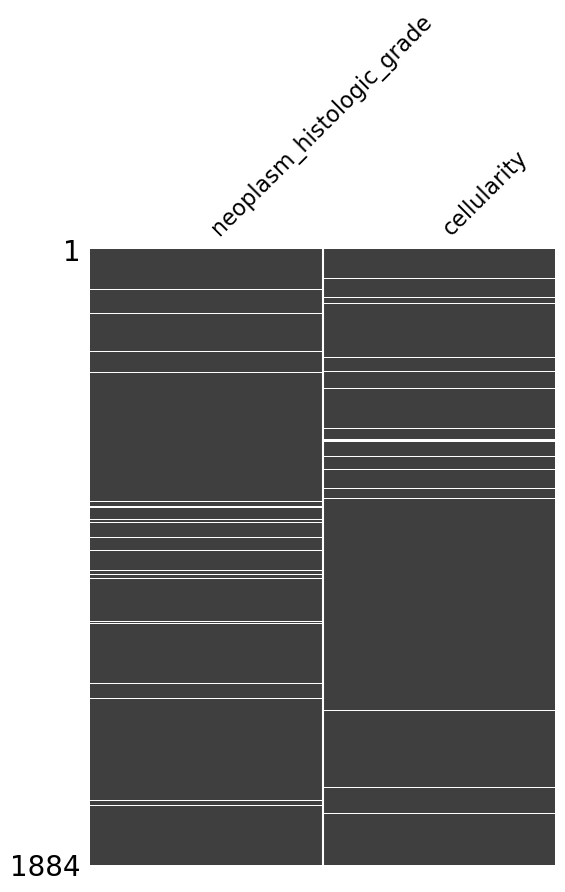

In [10]:
import missingno as msno

# 只对有缺失值的变量进行可视化
missing_vars = ["neoplasm_histologic_grade", "cellularity"]
msno.matrix(X_clinical[missing_vars], figsize=(6, 8), sparkline=False)
plt.show()

In [11]:
# 用众数填充cellularity的缺失值
mode_cellularity = X_clinical["cellularity"].mode()[0]  # "High"
X_clinical["cellularity"] = X_clinical["cellularity"].fillna(mode_cellularity)

In [12]:
# 将缺失转为新类别 "Grade Missing"
X_clinical["neoplasm_histologic_grade"] = (
    X_clinical["neoplasm_histologic_grade"]
    .fillna("Missing")  # 转为字符串，后续编码为独立类别
)

# 添加缺失指示变量（供LASSO选择）
X_clinical["grade_missing"] = (
    X_clinical["neoplasm_histologic_grade"].isnull()
).astype(int)

In [13]:
# 再计算各变量缺失率，都不缺失了
missing_stats = X_clinical.isnull().mean().sort_values(ascending=False)
missing_df = pd.DataFrame({
    "Missing_Count": X_clinical.isnull().sum(),
    "Missing_Ratio(%)": (missing_stats * 100).round(2)
})
print(missing_df)

                               Missing_Count  Missing_Ratio(%)
age_at_diagnosis                           0               0.0
neoplasm_histologic_grade                  0               0.0
pam50_+_claudin-low_subtype                0               0.0
er_status                                  0               0.0
her2_status                                0               0.0
inferred_menopausal_state                  0               0.0
lymph_nodes_examined_positive              0               0.0
cohort                                     0               0.0
cellularity                                0               0.0
grade_missing                              0               0.0


In [14]:
import pandas as pd

# 定义想要查看的变量列表
variables_to_check = [
    "neoplasm_histologic_grade",
    "pam50_+_claudin-low_subtype",
    "er_status",
    "her2_status",
    "inferred_menopausal_state",
    "cohort",
    "cellularity"
]

# 遍历每个变量并打印其唯一值
for var in variables_to_check:
    unique_values = X_clinical[var].unique()
    print(f"变量 '{var}' 的唯一取值为:")
    print(unique_values)

变量 'neoplasm_histologic_grade' 的唯一取值为:
[3.0 2.0 1.0 'Missing']
变量 'pam50_+_claudin-low_subtype' 的唯一取值为:
['claudin-low' 'LumA' 'LumB' 'Her2' 'Normal' 'Basal' 'NC']
变量 'er_status' 的唯一取值为:
['Positive' 'Negative']
变量 'her2_status' 的唯一取值为:
['Negative' 'Positive']
变量 'inferred_menopausal_state' 的唯一取值为:
['Post' 'Pre']
变量 'cohort' 的唯一取值为:
[1. 2. 3. 5. 4.]
变量 'cellularity' 的唯一取值为:
['High' 'Moderate' 'Low']


In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np

# --- 1. 创建一个最终的、空的DataFrame来存放所有特征 ---
X_final = pd.DataFrame()

# --- 2. 处理二分类变量 ---
binary_map = {
    "er_status": {"Negative": 0, "Positive": 1},
    "her2_status": {"Negative": 0, "Positive": 1},
    "inferred_menopausal_state": {"Pre": 0, "Post": 1}
}
for col, mapping in binary_map.items():
    X_final[col] = X_clinical[col].map(mapping)

# --- 3. 处理连续变量 ---
scaler = StandardScaler()

# 年龄
X_final["age_scaled"] = scaler.fit_transform(X_clinical[["age_at_diagnosis"]])

# 淋巴结：先log变换再标准化
lymph_log = np.log(X_clinical["lymph_nodes_examined_positive"] + 1)
X_final["lymph_log_scaled"] = scaler.fit_transform(lymph_log.values.reshape(-1, 1))

# --- 4. 处理分类变量（One-Hot编码）---
# 确保所有分类变量为字符串类型
X_clinical["neoplasm_histologic_grade"] = X_clinical["neoplasm_histologic_grade"].astype(str)
X_clinical["cellularity"] = X_clinical["cellularity"].astype(str)
X_clinical["pam50_+_claudin-low_subtype"] = X_clinical["pam50_+_claudin-low_subtype"].astype(str)
X_clinical["cohort"] = X_clinical["cohort"].astype(str)

# 创建一个列表来存放所有编码后的DataFrame
encoded_dfs = []

# ... (你的 One-Hot 编码代码，这部分是正确的) ...
# 1. neoplasm_histologic_grade
encoder = OneHotEncoder(drop=["1.0"], sparse_output=False)
encoder.fit(X_clinical[["neoplasm_histologic_grade"]])
encoded = encoder.transform(X_clinical[["neoplasm_histologic_grade"]])
names = encoder.get_feature_names_out(["neoplasm_histologic_grade"])
names = [n.replace("neoplasm_histologic_grade", "grade") for n in names]
grade_df = pd.DataFrame(encoded, columns=names, index=X_clinical.index)
encoded_dfs.append(grade_df)

# 2. cellularity
encoder = OneHotEncoder(drop=["High"], sparse_output=False)
encoder.fit(X_clinical[["cellularity"]])
encoded = encoder.transform(X_clinical[["cellularity"]])
names = encoder.get_feature_names_out(["cellularity"])
cell_df = pd.DataFrame(encoded, columns=names, index=X_clinical.index)
encoded_dfs.append(cell_df)

# 3. pam50_+_claudin-low_subtype
encoder = OneHotEncoder(drop=["LumA"], sparse_output=False)
encoder.fit(X_clinical[["pam50_+_claudin-low_subtype"]])
encoded = encoder.transform(X_clinical[["pam50_+_claudin-low_subtype"]])
names = encoder.get_feature_names_out(["pam50_+_claudin-low_subtype"])
names = [n.replace("pam50_+_claudin-low_subtype", "pam50") for n in names]
pam50_df = pd.DataFrame(encoded, columns=names, index=X_clinical.index)
encoded_dfs.append(pam50_df)

# 4. cohort
encoder = OneHotEncoder(drop=["1.0"], sparse_output=False)
encoder.fit(X_clinical[["cohort"]])
encoded = encoder.transform(X_clinical[["cohort"]])
names = encoder.get_feature_names_out(["cohort"])
cohort_df = pd.DataFrame(encoded, columns=names, index=X_clinical.index)
encoded_dfs.append(cohort_df)

# --- 5. 合并所有部分 ---
# 将 One-Hot 编码后的DataFrame合并成一个
X_categorical_encoded = pd.concat(encoded_dfs, axis=1)

# 将所有处理好的特征（二分类、连续、哑变量）合并到最终的DataFrame中
X_final = pd.concat([X_final, X_categorical_encoded], axis=1)

# --- 6. 现在你可以安全地提取了 ---
# Step 1: 提取二分类变量
binary_vars = ["er_status", "her2_status", "inferred_menopausal_state"]
X_binary = X_final[binary_vars].copy()

# Step 2: 提取标准化后的连续变量
continuous_vars = ["age_scaled", "lymph_log_scaled"]
X_continuous = X_final[continuous_vars].copy()

# 打印最终DataFrame的列名，确认所有特征都在
print("最终DataFrame的列名:")
print(X_final.columns.tolist())

最终DataFrame的列名:
['er_status', 'her2_status', 'inferred_menopausal_state', 'age_scaled', 'lymph_log_scaled', 'grade_2.0', 'grade_3.0', 'grade_Missing', 'cellularity_Low', 'cellularity_Moderate', 'pam50_Basal', 'pam50_Her2', 'pam50_LumB', 'pam50_NC', 'pam50_Normal', 'pam50_claudin-low', 'cohort_2.0', 'cohort_3.0', 'cohort_4.0', 'cohort_5.0']


In [17]:
import pandas as pd

# Step 1: 读取 hub gene 列表
hub_red = pd.read_csv("hub_genes_red_top20.csv")["gene"].tolist()
hub_brown = pd.read_csv("hub_genes_brown_top20.csv")["gene"].tolist()

# 合并并去重（虽然理论上无重复）
hub_genes = list(set(hub_red + hub_brown))
print(f"共提取 {len(hub_genes)} 个 hub genes")

# Step 2: 将基因名统一转为小写（METABRIC 数据列名为小写，如 'gata3'）
hub_genes_lower = [g.lower() for g in hub_genes]

# Step 3: 从主数据集 df_clean 中提取对应的基因表达列
# 注意：METABRIC 的基因列位于列 31 到 519（共 489 列），列名即为基因 symbol（小写）
gene_columns_in_data = df_clean.columns[31:520]  # 确保只取基因表达部分

# 检查哪些 hub genes 存在于数据中
available_genes = [g for g in hub_genes_lower if g in gene_columns_in_data]
missing_genes = [g for g in hub_genes_lower if g not in gene_columns_in_data]

print(f"  ├─ 成功匹配: {len(available_genes)} 个")
print(f"  └─ 未找到: {len(missing_genes)} 个 → {missing_genes}")

# Step 4: 提取基因表达数据（Z-score 已标准化，无需再处理）
X_genes = df_clean[available_genes].copy()

# 可选：按原始 hub 列表顺序排序（提升可读性）
hub_order = [g.lower() for g in (hub_red + hub_brown) if g.lower() in available_genes]
X_genes = X_genes[hub_order]  # 保持 red → brown 顺序

print(f"X_genes shape: {X_genes.shape}")
print("前5个基因:", X_genes.columns[:5].tolist())

共提取 40 个 hub genes
  ├─ 成功匹配: 40 个
  └─ 未找到: 0 个 → []
X_genes shape: (1884, 40)
前5个基因: ['gata3', 'mapt', 'igf1r', 'aph1b', 'bcl2']


In [18]:
import pandas as pd

# 已经得到了以下两个 DataFrame:
# X_final: 包含所有处理好的临床特征
# X_genes: 包含 40 个 hub 基因的表达数据

# --- 合并两个特征矩阵 ---
# 使用 pd.concat 进行横向合并 (axis=1)
X = pd.concat([X_final, X_genes], axis=1)

# --- 检查合并结果 ---
print("合并后的特征矩阵形状 (样本数, 特征数):")
print(X.shape)

print("\n合并后的前 5 行数据:")
print(X.head())

print("\n合并后的列名前 10 个:")
print(X.columns[:10].tolist())

print("\n合并后的列名后 10 个 (应该是基因名):")
print(X.columns[-10:].tolist())


合并后的特征矩阵形状 (样本数, 特征数):
(1884, 60)

合并后的前 5 行数据:
   er_status  her2_status  inferred_menopausal_state  age_scaled  \
0          1            0                          1    1.119081   
1          1            0                          0   -1.382139   
2          1            0                          0   -0.944464   
3          1            0                          0   -1.036160   
4          1            0                          1    1.220794   

   lymph_log_scaled  grade_2.0  grade_3.0  grade_Missing  cellularity_Low  \
0          2.103168        0.0        1.0            0.0              0.0   
1         -0.779511        0.0        1.0            0.0              0.0   
2          0.053770        1.0        0.0            0.0              0.0   
3          0.887052        1.0        0.0            0.0              0.0   
4          1.861928        0.0        1.0            0.0              0.0   

   cellularity_Moderate  ...    e2f7   rad51   chek2    rbl1  srd5a1    cdk2  \


In [19]:
from sklearn.model_selection import train_test_split

# 创建分层标签：使用 pam50 亚型（若不可用，用 grade）
# 注意：pam50 在 X 中列名为 'pam50_Basal', 'pam50_Her2'... 需还原原始类别

# 方法：从原始 df_clean 中提取 pam50（确保一致性）
stratify_labels = df_clean.loc[X.index, "pam50_+_claudin-low_subtype"].fillna("Unknown")

# 划分时按 pam50 分层
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=stratify_labels
)

print(f"训练集: {X_train.shape[0]} 样本")
print(f"测试集: {X_test.shape[0]} 样本")

# 验证分层效果
print("训练集:")
print(df_clean.loc[X_train.index, "pam50_+_claudin-low_subtype"].value_counts(normalize=True))
print("\n测试集:")
print(df_clean.loc[X_test.index, "pam50_+_claudin-low_subtype"].value_counts(normalize=True))

训练集: 1507 样本
测试集: 377 样本
训练集:
pam50_+_claudin-low_subtype
LumA           0.359655
LumB           0.242203
Her2           0.114798
Basal          0.104180
claudin-low    0.103517
Normal         0.072329
NC             0.003318
Name: proportion, dtype: float64

测试集:
pam50_+_claudin-low_subtype
LumA           0.360743
LumB           0.244032
Her2           0.114058
claudin-low    0.103448
Basal          0.103448
Normal         0.071618
NC             0.002653
Name: proportion, dtype: float64


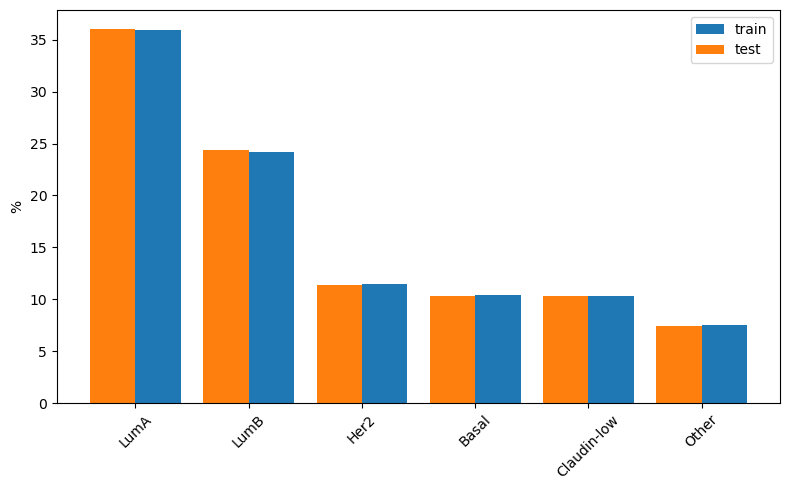

In [20]:
import matplotlib.pyplot as plt

# 你的分层结果
train_dist = {
    'LumA': 35.97, 'LumB': 24.22, 'Her2': 11.48,
    'Basal': 10.42, 'Claudin-low': 10.35, 'Other': 7.56
}
test_dist = {
    'LumA': 36.07, 'LumB': 24.40, 'Her2': 11.41,
    'Basal': 10.34, 'Claudin-low': 10.34, 'Other': 7.43
}

labels = list(train_dist.keys())
x = range(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x, train_dist.values(), width=0.4, label='train', align='edge')
plt.bar(x, test_dist.values(), width=-0.4, label='test', align='edge')
plt.xticks(x, labels, rotation=45)
plt.ylabel('%')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
from sklearn.linear_model import LassoCV
import numpy as np

# 使用 10 折交叉验证，搜索 100 个 λ 值
lasso = LassoCV(
    cv=10, 
    alphas=np.logspace(-4, 1, 100),  # λ 范围：0.0001 ~ 10
    random_state=42,
    n_jobs=-1  # 使用所有 CPU 核心
)

# 在训练集上拟合
lasso.fit(X_train, y_train)

# 最优 λ
print(f"最优正则化参数 λ (alpha): {lasso.alpha_:.6f}")

最优正则化参数 λ (alpha): 0.008302


In [22]:
# 获取非零系数的变量
selected_mask = lasso.coef_ != 0
selected_features = X_train.columns[selected_mask]
selected_coefs = lasso.coef_[selected_mask]

# 创建结果 DataFrame
lasso_results = pd.DataFrame({
    "Feature": selected_features,
    "LASSO_Coefficient": selected_coefs
}).sort_values("LASSO_Coefficient", key=abs, ascending=False)  # 按绝对值排序

print(f"\n LASSO 选出了 {len(selected_features)} 个显著预测因子:")
print(lasso_results)


 LASSO 选出了 23 个显著预测因子:
             Feature  LASSO_Coefficient
1   lymph_log_scaled           0.128471
0         age_scaled           0.047792
17              msh6           0.036778
10            acvr1b           0.032989
3         cohort_2.0          -0.023486
9               tbx3           0.019151
16             aurka           0.018754
20             ccnb1           0.018731
14             mapk3           0.016689
2          grade_3.0           0.015314
18             chek2           0.013008
6              ahnak          -0.011625
8             bmpr1b          -0.010225
19            srd5a1           0.007722
13              lfng          -0.007359
12           hsd17b8          -0.005894
22              e2f8           0.005044
4              igf1r          -0.003856
7               npnt           0.002726
21              map2          -0.002565
5              aph1b          -0.002018
11           hsd17b4          -0.001203
15           tp53bp1           0.000205


正在计算 LASSO 路径...


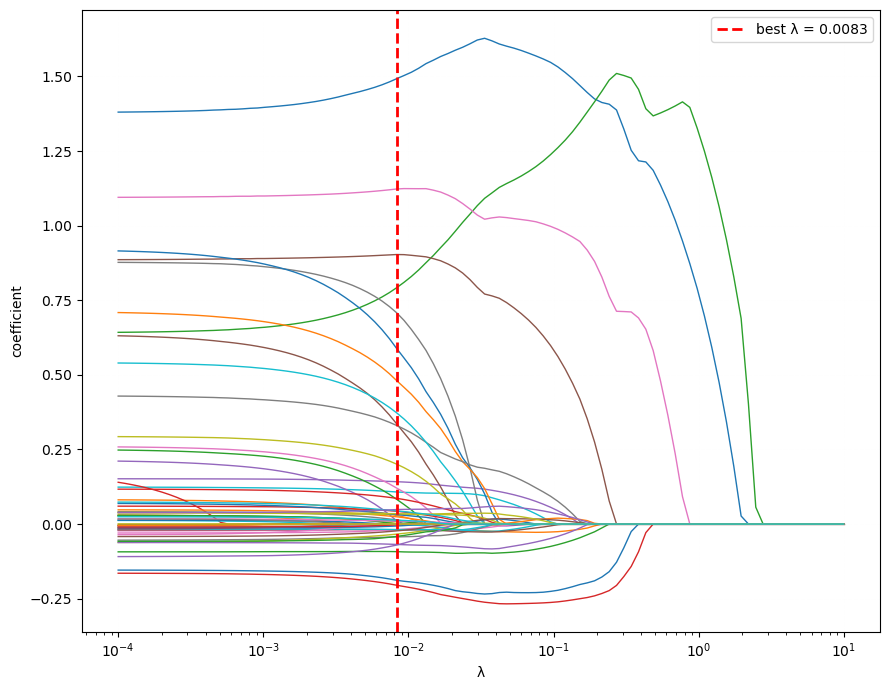

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path

# 1. 重新计算 LASSO 路径（使用训练集数据）
print("正在计算 LASSO 路径...")

# 注意：lasso_path 要求 X 已标准化（X 中临床变量已标准化，基因变量是 Z-score，符合要求）
alphas_lasso, coefs_lasso, _ = lasso_path(
    X_train, y_train,
    alphas=np.logspace(-4, 1, 100),  # 与 LassoCV 相同的 alpha 范围
    max_iter=10000
)

# 2. 绘制路径图
plt.figure(figsize=(9, 7))

# 绘制每条变量的路径
for i in range(coefs_lasso.shape[0]):
    plt.semilogx(alphas_lasso, coefs_lasso[i], lw=1)

# 标记最优 alpha（来自 LassoCV）
plt.axvline(lasso.alpha_, color='red', linestyle='--', linewidth=2, 
           label=f'best λ = {lasso.alpha_:.4f}')

plt.xlabel('λ')
plt.ylabel('coefficient')
plt.legend()
plt.grid(True, linestyle='--', alpha= 0.008302)
plt.tight_layout()
plt.show()

In [24]:
# Step 1: 定义变量组（每个原始变量对应的列名）
variable_groups = {
    # 连续/二分类变量（单列）
    "age_scaled": ["age_scaled"],
    "lymph_log_scaled": ["lymph_log_scaled"],
    "er_status": ["er_status"],
    "her2_status": ["her2_status"],
    "inferred_menopausal_state": ["inferred_menopausal_state"],
    "grade_Missing": ["grade_Missing"],  # 手动创建的缺失指示变量（单列）
    
    # 分类变量（多列哑变量）
    "neoplasm_histologic_grade": [col for col in X.columns if col.startswith("grade_") and col != "grade_Missing"],
    "cellularity": [col for col in X.columns if col.startswith("cellularity_")],
    "pam50": [col for col in X.columns if col.startswith("pam50_")],
    "cohort": [col for col in X.columns if col.startswith("cohort_")],
    
    # 基因变量（单列）
    # 基因无需分组，每个基因独立
}

In [25]:
# Step 2: 添加基因变量（每个基因单独作为一组）
hub_genes_list = pd.read_csv("hub_genes_red_top20.csv")["gene"].tolist() + \
                 pd.read_csv("hub_genes_brown_top20.csv")["gene"].tolist()
hub_genes_lower = [g.lower() for g in hub_genes_list]
for gene in hub_genes_lower:
    if gene in X.columns:
        variable_groups[gene] = [gene]

# Step 3: 检查哪些组被 LASSO 选中（组内任一变量被选中即保留整组）
selected_groups = []
for group_name, cols in variable_groups.items():
    if any(col in selected_features.tolist() for col in cols):
        selected_groups.extend(cols)

# 去重（防止重复添加）
selected_groups = list(set(selected_groups))

print(f"按组保留的变量数: {len(selected_groups)}")
print("新增的变量（因组保留）:", set(selected_groups) - set(selected_features))

按组保留的变量数: 27
新增的变量（因组保留）: {'cohort_3.0', 'cohort_5.0', 'grade_2.0', 'cohort_4.0'}


In [32]:
# Step 4: 用整组变量拟合 OLS
import statsmodels.api as sm
import numpy as np

# 使用按组保留的变量
X_train_selected = X_train[selected_groups]

# 拟合初始 OLS（用于诊断）
X_train_ols = sm.add_constant(X_train_selected)
initial_ols = sm.OLS(y_train, X_train_ols).fit()

print(initial_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             tumor_size   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     10.37
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           1.19e-39
Time:                        14:27:42   Log-Likelihood:                -920.70
No. Observations:                1507   AIC:                             1897.
Df Residuals:                    1479   BIC:                             2046.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.1973      0.042  

In [31]:
conda install statsmodels

3 channel Terms of Service accepted
Retrieving notices: done
Channels:
 - defaults
Platform: win-64
Solving environment: done

## Package Plan ##

  environment location: c:\ProgramData\miniconda3

  added / updated specs:
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-25.11.1              |  py313haa95532_0         1.2 MB
    patsy-1.0.1                |  py313haa95532_0         364 KB
    statsmodels-0.14.6         |  py313h02ab6af_0        11.0 MB
    ------------------------------------------------------------
                                           Total:        12.5 MB

The following NEW packages will be INSTALLED:

  patsy              pkgs/main/win-64::patsy-1.0.1-py313haa95532_0 
  statsmodels        pkgs/main/win-64::statsmodels-0.14.6-py313h02ab6af_0 

The following packages will be UPDATED:

  conda                             25.11.0-py313haa955

In [33]:
# 计算诊断指标
influence = initial_ols.get_influence()
residuals = initial_ols.resid
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

# 阈值（经验规则）
outlier_threshold = 3 * np.std(residuals)  # 异常点
leverage_threshold = 2 * (X_train_ols.shape[1] / X_train_ols.shape[0])  # 高杠杆点
cooks_threshold = 4 / X_train_ols.shape[0]  # 强影响点

# 识别问题样本
outliers = np.abs(residuals) > outlier_threshold
high_leverage = leverage > leverage_threshold
influential = cooks_d > cooks_threshold

print(f"异常点: {outliers.sum()} 个")
print(f"高杠杆点: {high_leverage.sum()} 个")
print(f"强影响点: {influential.sum()} 个")

异常点: 22 个
高杠杆点: 39 个
强影响点: 88 个


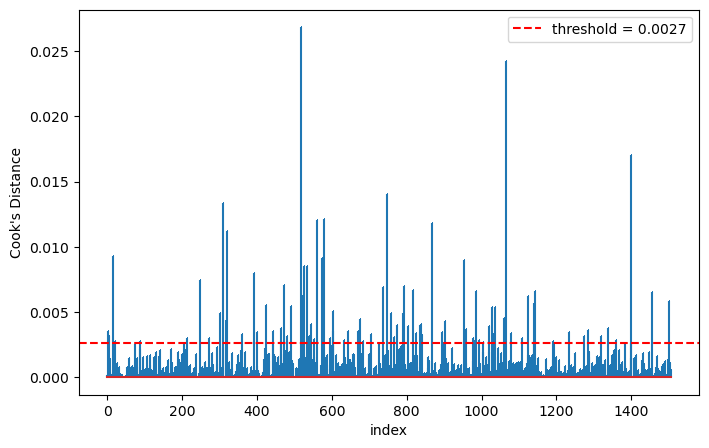

In [34]:
# 可视化 Cook's Distance
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=cooks_threshold, color='red', linestyle='--', label=f"threshold = {cooks_threshold:.4f}")
plt.xlabel("index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

In [35]:
# 获取强影响点的原始肿瘤大小
influential_indices = np.where(influential)[0]
influential_tumor_sizes = df_clean.iloc[X_train.index[influential_indices]]["tumor_size"]

print("强影响点的原始肿瘤大小 (mm):")
print(influential_tumor_sizes.values)

# 检查是否极端（如 > 100mm）
if (influential_tumor_sizes > 100).any():
    print("⚠️ 警告：强影响点包含极大肿瘤（>10cm），可能为真实病例！")
    print("建议：改用稳健回归（HuberRegressor）而非删除！")
else:
    print("强影响点肿瘤大小合理，可安全删除。")

强影响点的原始肿瘤大小 (mm):
[ 40.   38.  150.   28.   30.   35.   14.   12.   25.   25.1  30.   17.
  21.   39.   10.   10.   35.   18.   22.   18.   10.   14.   99.   20.
  61.   30.   20.   34.   20.   25.   20.   18.   28.  160.   15.   25.
  60.   20.   99.   20.   23.   30.   40.   17.   21.   20.   15.   15.
   8.   14.   45.   22.   48.   25.   12.   40.   30.   30.   80.   16.
  25.   30.   43.   30.   80.   18.   27.   15.   32.   70.   32.   25.
  25.   20.    3.   34.   29.   17.   25.   40.   20.   30.   20.   18.
  70.   12.   25.   20. ]
⚠️ 警告：强影响点包含极大肿瘤（>10cm），可能为真实病例！
建议：改用稳健回归（HuberRegressor）而非删除！


c:\ProgramData\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaV

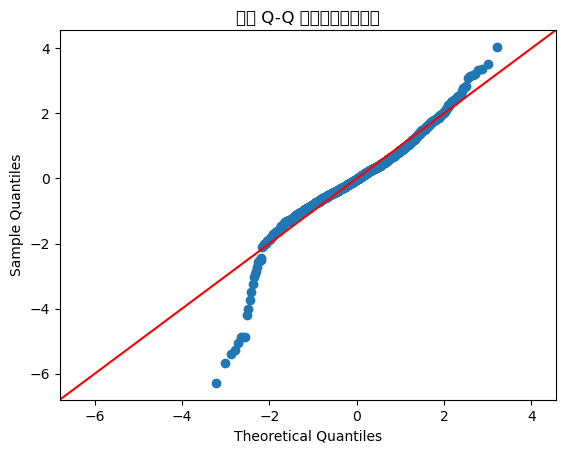

In [36]:
sm.qqplot(residuals, line='45', fit=True)
plt.title("残差 Q-Q 图（正态性检验）")
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
C:\Users\10632\AppData\Local\Temp\ipykernel_22280\4188600928.py:5: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel("$\hat{y}$")


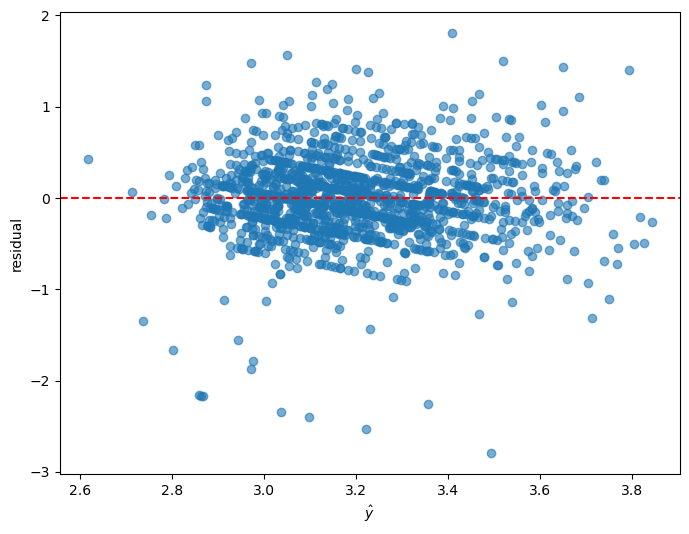

In [37]:
fitted = initial_ols.fittedvalues
plt.figure(figsize=(8, 6))
plt.scatter(fitted, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("$\hat{y}$")
plt.ylabel("residual")
plt.show()

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["变量"] = X_train_ols.columns
vif["VIF"] = [variance_inflation_factor(X_train_ols.values, i) for i in range(X_train_ols.shape[1])]
vif = vif[vif["变量"] != "const"].sort_values("VIF", ascending=False)
print(vif)

                  变量       VIF
17         grade_3.0  3.414699
12             aurka  2.969000
14         grade_2.0  2.644795
22             aph1b  2.444365
25             ccnb1  2.283208
23             igf1r  1.862243
11        cohort_3.0  1.832542
4              ahnak  1.775384
5               msh6  1.726499
6             bmpr1b  1.670327
15            srd5a1  1.643634
16             chek2  1.570154
20        cohort_2.0  1.564478
24           hsd17b8  1.508546
10           hsd17b4  1.479118
13           tp53bp1  1.478014
27              lfng  1.459889
2             acvr1b  1.449831
9               map2  1.449476
21              npnt  1.439476
26        cohort_4.0  1.394981
1               e2f8  1.394634
7               tbx3  1.376818
8              mapk3  1.373002
18        cohort_5.0  1.310841
3         age_scaled  1.216923
19  lymph_log_scaled  1.102195


In [39]:
from sklearn.metrics import mean_squared_error

# 方案B: 删除强影响点（谨慎！）
clean_idx = ~influential
X_clean = X_train_selected[clean_idx]
y_clean = y_train[clean_idx]
final_ols = sm.OLS(y_clean, sm.add_constant(X_clean)).fit()

print(final_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             tumor_size   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     14.93
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           2.57e-59
Time:                        14:28:08   Log-Likelihood:                -463.25
No. Observations:                1419   AIC:                             982.5
Df Residuals:                    1391   BIC:                             1130.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.1370      0.032  

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 用删除强影响点后的训练集拟合
final_model = LinearRegression().fit(X_train_selected[~influential], y_train[~influential])

# 在原始测试集预测（不删除测试集样本！）
y_test_pred = final_model.predict(X_test[selected_groups])

# 评估
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
print(f"测试集性能: RMSE = {rmse:.4f}, R² = {r2:.4f}")

测试集性能: RMSE = 0.4550, R² = 0.0663


In [41]:
# 1. 用训练集的数据进行预测
# 注意：这里要用的是删除了强影响点后的 X_train 和 y_train
y_train_pred = final_model.predict(X_train_selected[~influential])

# 2. 获取真实的训练集标签
y_train_true = y_train[~influential]

# 3. 计算训练集的 RMSE 和 MSE
train_mse = mean_squared_error(y_train_true, y_train_pred)
train_rmse = np.sqrt(train_mse)

print(f"训练集 RMSE: {train_rmse:.4f}")
print(f"测试集 RMSE: {rmse:.4f}") # 这是你之前算好的

# 4. 比较两者
if train_rmse < rmse:
    print("模型在训练集上表现更好，属于正常现象（只要差距不大就没过拟合）。")
else:
    print("注意：测试集误差比训练集还小，可能是测试集数据比较简单。")

训练集 RMSE: 0.3354
测试集 RMSE: 0.4550
模型在训练集上表现更好，属于正常现象（只要差距不大就没过拟合）。


In [37]:
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 用全部训练样本拟合稳健回归
huber = HuberRegressor().fit(X_train[selected_groups], y_train)

# 在测试集预测（不删除任何样本）
y_test_pred = huber.predict(X_test[selected_groups])

# 评估
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
print(f"稳健回归测试集性能: RMSE = {rmse:.4f}, R² = {r2:.4f}")

稳健回归测试集性能: RMSE = 0.4535, R² = 0.0723


依旧依托答辩

/opt/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


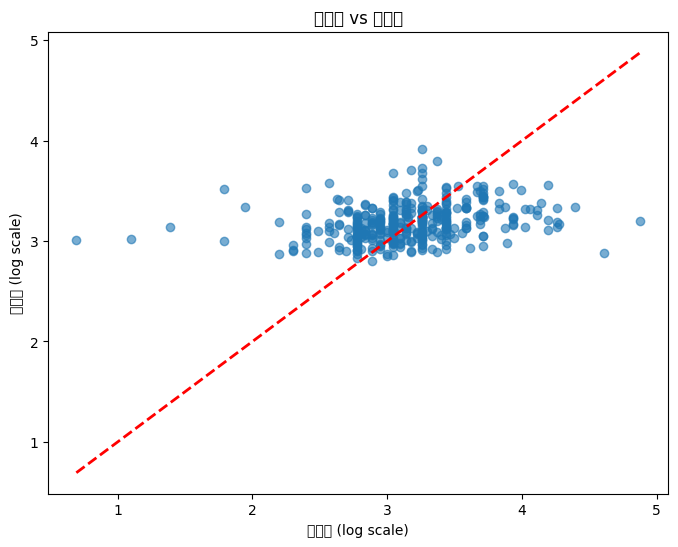

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('真实值 (log scale)')
plt.ylabel('预测值 (log scale)')
plt.title('预测值 vs 真实值')
plt.show()

In [43]:
# 按真实值分位数计算 RMSE
quantiles = np.percentile(y_test, [25, 50, 75])
rmse_by_quantile = []
for q in quantiles:
    mask = (y_test >= q - 0.2) & (y_test <= q + 0.2)
    rmse_q = np.sqrt(mean_squared_error(y_test[mask], y_test_pred[mask]))
    rmse_by_quantile.append(rmse_q)

print("不同分位数下的 RMSE:")
for i, q in enumerate(quantiles):
    print(f"第 {i+1} 个四分位数 (≈{q:.2f}): RMSE = {rmse_by_quantile[i]:.4f}")

不同分位数下的 RMSE:
第 1 个四分位数 (≈2.89): RMSE = 0.2844
第 2 个四分位数 (≈3.14): RMSE = 0.2051
第 3 个四分位数 (≈3.43): RMSE = 0.2570
